# Notebook Preamble

## IPython Magic

In [2]:
%load_ext autoreload
%autoreload 3

## Notebook Imports

In [ ]:
# 3rd Party Imports:
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import matplotx
import duckdb
import polars as pl
import dagster as dg
from dagster import AssetKey
from pathlib import Path
import os

In [4]:
# PUDL Imports
import pudl
from pudl.etl import defs
from pudl.workspace.setup import PudlPaths

In [5]:
logger = pudl.logging_helpers.get_logger("pudl")
os.environ["PUDL_INPUT"]

'/Users/zane/code/catalyst/pudl-input'

## Visualization Settings

In [6]:
%matplotlib inline

In [7]:
matplotlib.rcParams["figure.figsize"] = (10, 6)
matplotlib.rcParams["figure.dpi"] = 150
matplotlib.style.use(matplotx.styles.onedark)

pd.set_option("display.max_columns", 100)
pd.set_option("display.max_rows", 300)
pd.set_option("display.max_colwidth", 1000)

pl.Config.set_tbl_rows(100)
pl.Config.set_tbl_cols(100)
pl.Config.set_fmt_str_lengths(100)

polars.config.Config

## Set up data access shortcuts

In [8]:
from pudl.helpers import get_parquet_table as get_parquet
import geopandas as gpd

def get_asset(table: str) -> pd.DataFrame | gpd.GeoDataFrame:
    return defs.load_asset_value(AssetKey(table))

def get_pandas(table: str) -> pd.DataFrame:
    return pd.read_parquet(
        Path(os.environ["PUDL_OUTPUT"]) / f"parquet/{table}.parquet",
        memory_map=True,
        engine="pyarrow",
    ).convert_dtypes()

def get_polars(table: str) -> pl.DataFrame:
    return pl.read_parquet(
        Path(os.environ["PUDL_OUTPUT"]) / f"parquet/{table}.parquet",
    )

def get_pyarrow(table: str) -> pd.DataFrame:
    return pd.read_parquet(
        Path(os.environ["PUDL_OUTPUT"]) / f"parquet/{table}.parquet",
        dtype_backend="pyarrow",
        memory_map=True,
        engine="pyarrow",
    )


In [9]:
companies = get_polars("out_sec10k__quarterly_company_information")
filings = get_polars("out_sec10k__quarterly_filings")
parsubs = get_polars("out_sec10k__parents_and_subsidiaries")
name_changes = get_polars("out_sec10k__changelog_company_name")
ex21 = get_polars("core_sec10k__quarterly_exhibit_21_company_ownership")

## What fraction of electricity companies are linked to EIA utilities?

### Identify industry IDs with lots of Utility ID associations

- This is kind of begging the question, but it's not a terrible way to find interesting SICs to look at.
- Unsurprisingly the two top SICs with the largest number of Utility ID associations are electric services, and electric & other services combined (many seem to be combined electric & gas utilities)
- There's also a number of "real estate" oriented industries. Maybe they have big behind-the-meter C&I solar installations?
- There are also a number of industries that typically engage in cogeneration, especially papermills, oil & gas, natural gas transmission companies, etc.
- Filtering all the industry names for "electric" and "power" shows a bunch of other industries that are not related to electricity generation. Mostly electronics, etc.
- So the 4911 and 4931 seem to be the main ones we expect to link to EIA Utilities.
- And then there's a number of smaller industries with cogeneration that often match, but don't have as many companies in them, and probably aren't responsible for much generation.
- Note: this kind of analysis would be easier if we cleaned up the SIC names & IDs so that they're more consistent & complete.

In [ ]:
(
    get_polars("out_sec10k__quarterly_company_information")
    .filter(pl.col("utility_id_eia").is_not_null())
    .select(["industry_id_sic", "industry_name_sic"])
    .group_by(["industry_id_sic", "industry_name_sic"])
    .agg(pl.len().alias("count"))
    .sort("count", descending=True)
    .head(20)
)

industry_id_sic,industry_name_sic,count
str,str,u32
"""4911""","""electric services""",6661
"""4931""","""electric & other services combined""",2041
"""6798""","""real estate investment trusts""",402
"""6189""","""asset-backed securities""",368
"""4911""",null,228
"""1311""","""crude petroleum & natural gas""",222
"""2621""","""paper mills""",174
"""2834""","""pharmaceutical preparations""",173
null,null,135


In [20]:
electricity_sics = (
    get_polars("out_sec10k__quarterly_company_information")
    .group_by(sic=pl.col("industry_id_sic"))
    .agg(
        fraction_with_utility_id=pl.col("utility_id_eia").is_not_null().mean()
    )
    .sort("fraction_with_utility_id", descending=True)
    .head(20)
    #.filter(pl.col("fraction_with_utility_id") > 0.50)
    #.select("sic").to_series().to_list()
)
electricity_sics

sic,fraction_with_utility_id
str,f64
"""4911""",0.584408
"""2631""",0.542601
"""4991""",0.542017
"""4931""",0.51861
"""2621""",0.406181
"""2600""",0.4
"""2650""",0.34375
"""3011""",0.269565
"""3760""",0.267516


In [19]:
(
    get_polars("out_sec10k__quarterly_company_information")
    .filter(pl.col("industry_id_sic").is_in(electricity_sics))
    .select(["industry_id_sic", "industry_name_sic"])
    .group_by(["industry_id_sic", "industry_name_sic"])
    .agg(pl.len().alias("count"))
    .sort("count", descending=True)
)

industry_id_sic,industry_name_sic,count
str,str,u32
"""4911""","""electric services""",11368
"""4931""","""electric & other services combined""",3941
"""4911""",null,420
"""4991""","""cogeneration services & small power producers""",233
"""2631""","""paperboard mills""",209
"""4931""",null,116
"""2631""",null,14
"""4991""",null,5


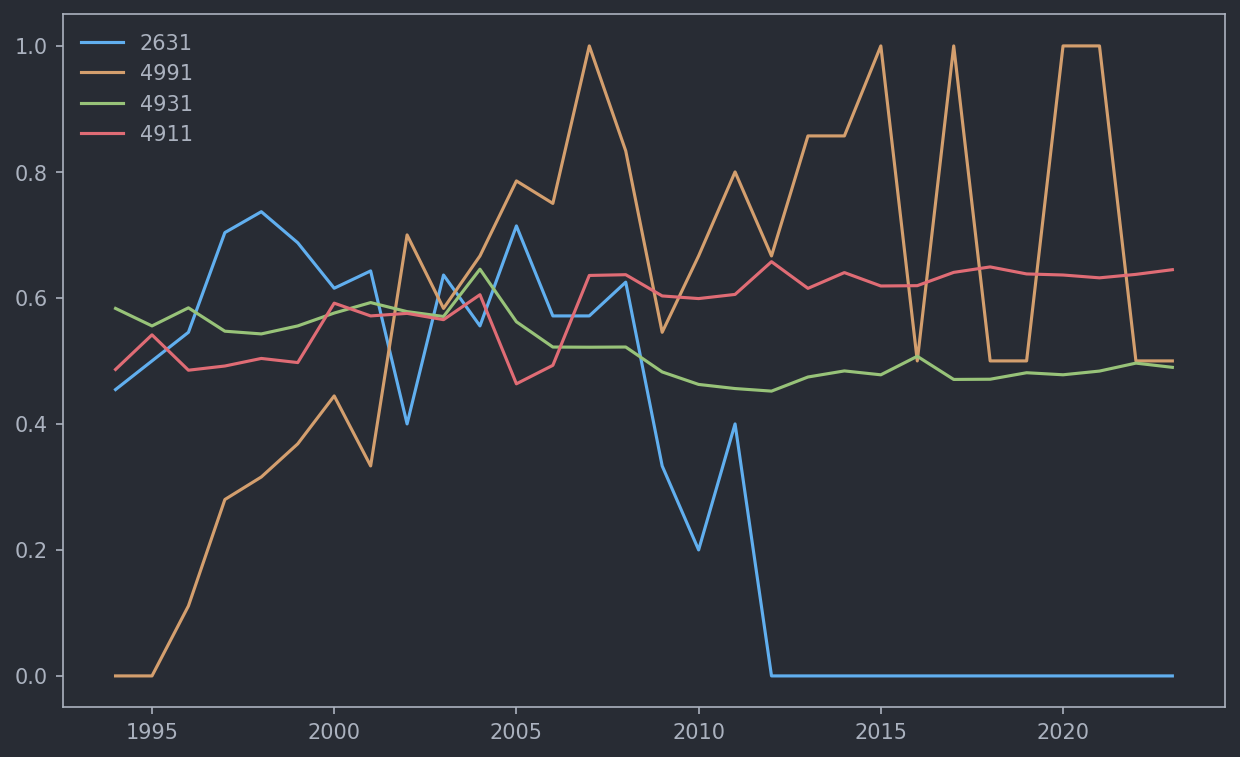

In [78]:
util_ids_by_year = get_polars("out_sec10k__quarterly_company_information").filter(
    pl.col("industry_id_sic").is_in(electricity_sics),
).with_columns(
    year=pl.col("report_date").dt.year()
).group_by(["year", "industry_id_sic"]).agg(
    fraction_with_utility_id=pl.col("utility_id_eia").is_not_null().mean(),
).sort("year")

for sic in util_ids_by_year["industry_id_sic"].unique():
    df = util_ids_by_year.filter(pl.col("industry_id_sic") == sic)
    plt.plot(df["year"], df["fraction_with_utility_id"], label=sic)

plt.legend()

In [87]:
unmatched_companies = (
    get_polars("out_sec10k__quarterly_company_information")
    .filter(
        pl.col("industry_id_sic").is_in(["4911", "4931"]),
        pl.col("utility_id_eia").is_not_null(),
    )
    .select(["company_name", "utility_name_eia", "report_date"])
    .unique(["company_name", "utility_name_eia", "report_date"])
)
unmatched_companies.sample(30).sort("report_date")

company_name,utility_name_eia,report_date
str,str,date
"""pacific gas & electric co""","""Pacific Gas & Electric Co.""",1994-01-01
"""public service electric & gas co""","""Public Service Electric&Gas Co""",1994-01-01
"""south carolina electric & gas co""","""South Carolina Electric&Gas Co""",1995-01-01
"""southwestern electric power co""","""Southwestern Electric Power Co""",1998-01-01
"""indiana michigan power co""","""Indiana Michigan Power Co""",1998-04-01
"""dominion resources inc /va/""","""Dominion Energy Inc""",1999-01-01
"""union light heat & power co""","""Duke Energy Commercial Asset Management""",2001-01-01
"""pacific gas & electric co""","""Pacific Gas & Electric Co.""",2002-01-01
"""indiantown cogeneration lp""","""Indiantown Cogeneration LP""",2002-04-01


In [42]:
(
    get_polars("out_sec10k__parents_and_subsidiaries")[
        "report_date",
        "parent_company_central_index_key",
        "parent_company_utility_id_eia",
        "parent_company_name",
        "subsidiary_company_id_sec10k",
        "subsidiary_company_central_index_key",
        "subsidiary_company_utility_id_eia",
        "subsidiary_company_name",
        "fraction_owned",
    ].filter(
        pl.col("report_date").dt.year().is_in([2001, 2023]),
        pl.col("parent_company_central_index_key").eq("0000072903")
    )
)

report_date,parent_company_central_index_key,parent_company_utility_id_eia,parent_company_name,subsidiary_company_id_sec10k,subsidiary_company_central_index_key,subsidiary_company_utility_id_eia,subsidiary_company_name,fraction_owned
date,str,i32,str,str,str,i32,str,f32
2023-01-01,"""0000072903""",56149,"""xcel energy inc""","""0000072903_nicollet holdings company llc_minnesota""",null,null,"""nicollet holdings company llc""",null
2023-01-01,"""0000072903""",56149,"""xcel energy inc""","""0000072903_nicollet project holdings llc_minnesota""",null,null,"""nicollet project holdings llc""",null
2023-01-01,"""0000072903""",56149,"""xcel energy inc""","""0000072903_northern states power company_minnesota minnesota""","""0001123852""",null,"""northern states power company""",null
2023-01-01,"""0000072903""",56149,"""xcel energy inc""","""0000072903_northern states power company_wisconsin wisconsin""","""0000072909""",null,"""northern states power company""",null
2023-01-01,"""0000072903""",56149,"""xcel energy inc""","""0000072903_public service company of colorado_colorado""","""0000081018""",null,"""public service company of colorado""",null
2023-01-01,"""0000072903""",56149,"""xcel energy inc""","""0000072903_southwestern public service company_new mexico""","""0000092521""",null,"""southwestern public service company""",null
2023-01-01,"""0000072903""",56149,"""xcel energy inc""","""0000072903_westgas interstate, inc_colorado""",null,null,"""westgas interstate, inc""",null
2023-01-01,"""0000072903""",56149,"""xcel energy inc""","""0000072903_xcel energy communications group inc_minnesota""",null,null,"""xcel energy communications group inc""",null
2023-01-01,"""0000072903""",56149,"""xcel energy inc""","""0000072903_xcel energy international inc_delaware""",null,null,"""xcel energy international inc""",null


In [ ]:
electricity_sics = ["4911", "4931"]
sics = ["4911", "4931", "6798", "6189", "1311", "2621", "2834", "4991", "4922", "4961", "2631", "7372", "4924", "3674", "2911"]
companies.filter(
    pl.col("utility_id_eia").is_not_null(),
    pl.col("industry_id_sic").is_in(sics)
).group_by(["industry_name_sic"]).len().sort("len", descending=True)

industry_name_sic,len
str,u32
"""electric services""",6661
"""electric & other services combined""",2041
"""real estate investment trusts""",402
"""asset-backed securities""",368
null,357
"""crude petroleum & natural gas""",222
"""paper mills""",174
"""pharmaceutical preparations""",173
"""cogeneration services & small power producers""",127


In [16]:
companies.filter(
    # pl.col("utility_id_eia").is_not_null(),
    pl.col("industry_name_sic").str.contains(".*(electricity|power).*")
).select(["industry_name_sic", "industry_id_sic"]).group_by("industry_id_sic").len().sort("len", descending=True)

industry_id_sic,len
str,u32
"""3825""",814
"""1623""",264
"""4991""",233
"""3612""",66


In [ ]:
assert False

In [ ]:
ex21_own = get_table("core_sec10k__quarterly_exhibit_21_company_ownership")
ex21_own.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3819795 entries, 0 to 3819794
Data columns (total 9 columns):
 #   Column                            Dtype        
---  ------                            -----        
 0   filename_sec10k                   string       
 1   report_date                       datetime64[s]
 2   parent_company_central_index_key  string       
 3   parent_company_name               string       
 4   subsidiary_company_name           string       
 5   subsidiary_company_location       string       
 6   subsidiary_company_id_sec10k      string       
 7   fraction_owned                    float64      
 8   filing_date                       datetime64[s]
dtypes: datetime64[s](2), float64(1), string(6)
memory usage: 262.3 MB


: 

In [ ]:
raw_filings = get_asset("raw_sec10k__quarterly_filings")
raw_company_info = get_asset("raw_sec10k__quarterly_company_information")
raw_ownership = get_asset("raw_sec10k__exhibit_21_company_ownership")
raw_parsubs = get_asset("raw_sec10k__parents_and_subsidiaries")

core_filings = get_asset("core_sec10k__quarterly_filings")
out_filings = get_asset("out_sec10k__quarterly_filings")

2025-04-09 15:42:18 -0600 - dagster - DEBUG - system - Loading file from: /Users/zane/code/catalyst/dagster-home/storage/raw_sec10k__quarterly_filings using PickledObjectFilesystemIOManager...
2025-04-09 15:42:18 -0600 - dagster - DEBUG - system - Loading file from: /Users/zane/code/catalyst/dagster-home/storage/raw_sec10k__quarterly_company_information using PickledObjectFilesystemIOManager...
2025-04-09 15:42:19 -0600 - dagster - DEBUG - system - Loading file from: /Users/zane/code/catalyst/dagster-home/storage/raw_sec10k__exhibit_21_company_ownership using PickledObjectFilesystemIOManager...
2025-04-09 15:42:20 -0600 - dagster - DEBUG - system - Loading file from: /Users/zane/code/catalyst/dagster-home/storage/raw_sec10k__parents_and_subsidiaries using PickledObjectFilesystemIOManager...


: 

In [ ]:
core_info = get_table("core_sec10k__quarterly_company_information")
raw_info = get_table("raw_sec10k__quarterly_company_information")
#file_sec10k = get_table("core_sec10k__quarterly_filings")
#own_sec10k = get_table("core_sec10k__quarterly_exhibit_21_company_ownership")
#out_sec10k = get_table("out_sec10k__parents_and_subsidiaries")
#name_change_sec10k = get_table("core_sec10k__changelog_company_name")

2025-03-08 15:27:38 -0600 - dagster - DEBUG - system - Loading file from: /Users/zane/code/catalyst/dagster-home/storage/core_sec10k__quarterly_company_information using PickledObjectFilesystemIOManager...
2025-03-08 15:27:38 -0600 - dagster - DEBUG - system - Loading file from: /Users/zane/code/catalyst/dagster-home/storage/raw_sec10k__quarterly_company_information using PickledObjectFilesystemIOManager...


: 

In [ ]:
business_address, company_data, filing_values, mail_address, former_company = core_sec10k__quarterly_company_information(raw_info)
company_info = pd.concat(
    [
        company_data,
        business_address,
        mail_address,
    ], axis="columns"
)

: 

## Splitting Company Info

### Company data
- 3 of the 5 tables that can be pulled out of this data seem to pertain to companies -- static or slowly changing dimensions.
- This data comes from the `business_address`, `mail_address` and `company_data` sub-tables.
- If we concatenate these sets of columns together, what natural primary keys do we end up with.
- Note that the `report_date` is not an independent field -- each filename seems to imply a specific report date.
- The relationship between filename and report date seems to be naturally homed in the "master filer" table.
- There's a directly reported CIK in the company data, but also a "master filer" CIK that can be extracted from the filename.
- Having both the master filer and the company CIKs in the same table might be useful, and could indicate whether the company is a subsidiary.
- The filename is mostly for provenance -- where did this data come from.
- If the reported data fields (address, TIN, name, fiscal year, etc.) are truly identical, then we don't lose any information about the companies by deduplicating them.
- We can drop the providencial / index information (filename, company & file information block counts) and then drop duplicates, and have a unique collection of company information.
- In an ideal world this information would not include any CIK + date duplicates but...

### Company naming history
- There's a kind of "sub-table" that's associated with the company data, which describes the history of the company names.
- The whole history seems to be reported in each filing, so there's lots of duplication.
- Alone, this table only has the "former" names and the dates of changes away from those former names.
- Being able to merge in the report date, filename, current company name and CIK from the company table will make this table more legible / useful.
- With all of that information there will be a ton of duplication, but also probably lots of useful ways to deduplicate it in a subsequent step.
- Maybe this is a raw or intermediate table that gets handed off for subsequent processing.

### Filing data
- There's also some filin-level data that's associatd with the company data.
- On cursory inspection, it seems like a lot of the duplicate values that show up when trying to create a naturla primary key if we concatenate the filing data with the company data are actually due to the filing data.
- If we separate the filing data out we may get a granular filing history that's separate from the less variable company data?
- The same SEC filing number can show up many times because amendments and the filings they amend share the same filing number.
- 


In [ ]:
# On what basis is this table unique?

# True!!!
# company_info.index.is_unique

# True!!!
# company_info.reset_index().set_index(["filename_sec10k", "filer_count", "company_information_block_count"]).index.is_unique

# False!!!
# company_info.reset_index().set_index(["filename_sec10k", "company_information_block_count"]).index.is_unique

# False!!!
# company_info.reset_index().set_index(["central_index_key", "report_date"]).index.is_unique

# False!!!
# company_info.reset_index().set_index(["filename_sec10k", "filer_count"]).index.is_unique

dude = company_info.reset_index().set_index(["central_index_key", "report_date"]).sort_index().reset_index()
mask = dude.duplicated(subset=["central_index_key", "report_date"], keep=False)
#dude.loc[mask, ~dude.columns.str.match(f"^(business_|mail_)")].sort_values(["central_index_key", "report_date"]).head(50)
dude.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 424429 entries, 0 to 424428
Data columns (total 21 columns):
 #   Column                              Non-Null Count   Dtype         
---  ------                              --------------   -----         
 0   central_index_key                   401565 non-null  string        
 1   report_date                         424429 non-null  datetime64[ns]
 2   filename_sec10k                     424429 non-null  object        
 3   filer_count                         424429 non-null  int64         
 4   company_information_block_count     424429 non-null  int64         
 5   company_conformed_name              401547 non-null  string        
 6   fiscal_year_end                     373481 non-null  string        
 7   irs_number                          378550 non-null  string        
 8   standard_industrial_classification  346469 non-null  string        
 9   state_of_incorporation              363564 non-null  string        
 10  business

: 

In [ ]:
dude.drop(columns=["filename_sec10k", "filer_count", "company_information_block_count"]).drop_duplicates().info()

<class 'pandas.core.frame.DataFrame'>
Index: 268567 entries, 0 to 424424
Data columns (total 18 columns):
 #   Column                              Non-Null Count   Dtype         
---  ------                              --------------   -----         
 0   central_index_key                   267950 non-null  string        
 1   report_date                         268567 non-null  datetime64[ns]
 2   company_conformed_name              267932 non-null  string        
 3   fiscal_year_end                     258107 non-null  string        
 4   irs_number                          252798 non-null  string        
 5   standard_industrial_classification  263103 non-null  string        
 6   state_of_incorporation              246614 non-null  string        
 7   business_phone                      260945 non-null  string        
 8   business_city                       266434 non-null  string        
 9   business_state                      266240 non-null  string        
 10  business_stre

: 

In [ ]:
deduplicated = (
    dude.drop(columns=["filename_sec10k", "filer_count", "company_information_block_count"])
    .drop_duplicates()
    .set_index(["central_index_key", "report_date"])
    .sort_index()
    .reset_index()
)
dupes = deduplicated[deduplicated.duplicated(subset=["central_index_key", "report_date"], keep=False)]

: 

In [ ]:
dupes.set_index(["central_index_key", "report_date"]).head(500).tail(50)

company_conformed_name fiscal_year_end irs_number                                  standard_industrial_classification state_of_incorporation business_phone    business_city business_state                 business_street_1            business_street_2 business_zip      mail_city mail_state                     mail_street_1                       mail_street_2    mail_zip
central_index_key report_date                                                                                                                                                                                                                                                                                                                                                                                                  
0000731625        1997-01-01        hospital staffing services inc            1130  592150637                           services-home health care services [8082]                     fl     3057710500  fort lauderdale             fl            6245 n federal highway                       ste400        33308  ft lauderdale         fl                6245 north fed hwy                           suite 400       33308
0000732485        1996-04-01                          genzyme corp            1231  061047163                                  pharmaceutical preparations [2834]                     ma     6172527500        cambridge             ma                one kendall square                         <NA>        02139      cambridge         ma                one kendall square                                <NA>       02139
                  1996-04-01                          genzyme corp            1231  061047163                                  pharmaceutical preparations [2834]                     ma     6172527500        cambridge             ma                    one kendall sq                         <NA>        02139      cambridge         ma                one kendall square                                <NA>       02139
0000735553        1995-01-01             first financial corp /wi/            1231  391471963                                                                6035                     wi     7153410400    stevens point             wi                      1305 main st                         <NA>        54481        stevens         wi                              <NA>                        1305 main st       54481
                  1995-01-01             first financial corp /wi/            1231  391471963                     savings institution, federally chartered [6035]                     wi     7153410400    stevens point             wi                      1305 main st                         <NA>        54481        stevens         wi                              <NA>                        1305 main st       54481
0000735571        1998-07-01                       warrantech corp            0331  133178732                                                                7389                     de     2039751100         stamford             ct                   300 atlantic st                         <NA>        06901       stamford         ct               300 atlantic street                 300 atlantic street       06901
                  1998-07-01                       warrantech corp            0331  133178732                              services-business services, nec [7389]                     de     2039751100         stamford             ct                   300 atlantic st                         <NA>        06901       stamford         ct               300 atlantic street                 300 atlantic street       06901
0000735584        1995-04-01                     50 off stores inc            0202  742640559                                        retail-variety stores [5331]                     tx     2108059300      san antonio             tx                 8750 tesoro drive                         <NA>   782

: 

In [ ]:
business_address.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 400016 entries, ('edgar/data/1000015/0000912057-00-014793.txt', np.int64(0), Timestamp('2000-01-01 00:00:00'), np.int64(0)) to ('edgar/data/99974/0001047469-98-014966.txt', np.int64(0), Timestamp('1998-04-01 00:00:00'), np.int64(0))
Data columns (total 6 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   business_phone     391855 non-null  object
 1   business_city      399623 non-null  object
 2   business_state     399367 non-null  object
 3   business_street_1  399435 non-null  object
 4   business_street_2  166632 non-null  object
 5   business_zip       398645 non-null  object
dtypes: object(6)
memory usage: 31.3+ MB


: 

In [ ]:
company_data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 401565 entries, ('edgar/data/1000015/0000912057-00-014793.txt', np.int64(0), Timestamp('2000-01-01 00:00:00'), np.int64(0)) to ('edgar/data/99974/0001047469-98-014966.txt', np.int64(0), Timestamp('1998-04-01 00:00:00'), np.int64(0))
Data columns (total 7 columns):
 #   Column                              Non-Null Count   Dtype 
---  ------                              --------------   ----- 
 0   central_index_key                   401565 non-null  object
 1   company_conformed_name              401547 non-null  object
 2   fiscal_year_end                     373481 non-null  object
 3   irs_number                          378550 non-null  object
 4   organization_name                   72 non-null      object
 5   standard_industrial_classification  346469 non-null  object
 6   state_of_incorporation              363564 non-null  object
dtypes: object(7)
memory usage: 34.4+ MB


: 

In [ ]:
filing_values.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 401565 entries, ('edgar/data/1000015/0000912057-00-014793.txt', np.int64(0), Timestamp('2000-01-01 00:00:00'), np.int64(0)) to ('edgar/data/99974/0001047469-98-014966.txt', np.int64(0), Timestamp('1998-04-01 00:00:00'), np.int64(0))
Data columns (total 4 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   film_number      401490 non-null  object
 1   form_type        401565 non-null  object
 2   sec_act          321669 non-null  object
 3   sec_file_number  401564 non-null  object
dtypes: object(4)
memory usage: 25.2+ MB


: 

In [ ]:
mail_address.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 373157 entries, ('edgar/data/1000015/0000912057-00-014793.txt', np.int64(0), Timestamp('2000-01-01 00:00:00'), np.int64(0)) to ('edgar/data/99974/0001047469-98-014966.txt', np.int64(0), Timestamp('1998-04-01 00:00:00'), np.int64(0))
Data columns (total 5 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   mail_city      372885 non-null  object
 1   mail_state     372557 non-null  object
 2   mail_street_1  370621 non-null  object
 3   mail_street_2  163935 non-null  object
 4   mail_zip       372103 non-null  object
dtypes: object(5)
memory usage: 26.8+ MB


: 

In [ ]:
dude = (
    former_company.reset_index()
    .assign(
        central_index_key=lambda x: x.filename_sec10k.str.split("/").str[2].str.zfill(10),
        name_change_date=lambda x: pd.to_datetime(x.date_of_name_change, format="%Y%m%d")
    )
    .sort_values(["central_index_key", "report_date"])
    .drop(columns=["date_of_name_change"])
    .drop_duplicates(subset=[
        "central_index_key",
        "name_change_date",
        "former_conformed_name",
    ], keep="last")
    .sort_values(["central_index_key", "name_change_date"])
)
display(dude.info())
dude.head(50)[
    [
        "central_index_key",
        "name_change_date",
        "former_conformed_name",
        "report_date",
        "filename_sec10k",
        "filer_count",
        "company_information_block_count",
    ]
]

<class 'pandas.core.frame.DataFrame'>
Index: 25237 entries, 95330 to 98402
Data columns (total 7 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   filename_sec10k                  25237 non-null  object        
 1   filer_count                      25237 non-null  int64         
 2   report_date                      25237 non-null  datetime64[ns]
 3   company_information_block_count  25237 non-null  int64         
 4   former_conformed_name            25235 non-null  object        
 5   central_index_key                25237 non-null  object        
 6   name_change_date                 25237 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(3)
memory usage: 1.5+ MB


None

,central_index_key,name_change_date,former_conformed_name,report_date,filename_sec10k,filer_count,company_information_block_count
95330,0000001750,1970-02-04,allen aircraft radio inc,2023-07-01,edgar/data/1750/0001104659-23-082069.txt,0,0
95569,0000001761,1968-08-09,ace cigarette service co,1997-04-01,edgar/data/1761/0000950152-97-004245.txt,0,1
95568,0000001761,1984-01-18,aav companies,1997-04-01,edgar/data/1761/0000950152-97-004245.txt,0,0
97442,0000001853,2000-01-01,aberdeen idaho mining co,2010-04-01,edgar/data/1853/0001266068-10-000020.txt,0,0
97994,0000001923,1992-07-03,abrams industries inc,2011-07-01,edgar/data/1923/0000950123-11-070238.txt,0,0
98160,0000001952,1972-10-11,north lime corp,2000-01-01,edgar/data/1952/0000001952-00-000002.txt,0,1
98159,0000001952,1984-04-09,ac&s corp,2000-01-01,edgar/data/1952/0000001952-00-000002.txt,0,0
98230,0000001961,1969-03-18,computer industries ltd,1997-10-01,edgar/data/1961/0000903893-97-001396.txt,0,0
98241,0000001961,1992-07-03,academic computer systems inc,2011-01-01,edgar/data/1961/0001264931-11-000102.txt,0,2
98292,0000001961,1998-02-13,worlds inc,2023-01-01,edgar/data/1961/0001264931-23-000006.txt,0,2


: 

In [ ]:
raw_info[(raw_info.filer_count != raw_info.company_information_block_count)]

,filename_sec10k,filer_count,company_information_block,company_information_block_count,company_information_fact_name,company_information_fact_value,year_quarter,report_date
22,edgar/data/100240/0000950144-94-000787.txt,0,former_company,1,former_conformed_name,rice broadcasting co inc,1994q1,1994-01-01
23,edgar/data/100240/0000950144-94-000787.txt,0,former_company,1,date_of_name_change,19700909,1994q1,1994-01-01
332,edgar/data/101829/0000101829-94-000019.txt,0,former_company,1,former_conformed_name,united technologies corp,1994q1,1994-01-01
333,edgar/data/101829/0000101829-94-000019.txt,0,former_company,1,date_of_name_change,19841205,1994q1,1994-01-01
357,edgar/data/101830/0000101830-94-000006.txt,0,former_company,1,former_conformed_name,united utilities inc,1994q1,1994-01-01
...,...,...,...,...,...,...,...,...
7980842,edgar/data/933974/0001558370-23-019262.txt,0,former_company,2,date_of_name_change,20020514,2023q4,2023-10-01
7980904,edgar/data/936528/0000936528-23-000207.txt,0,former_company,1,former_conformed_name,wafd inc,2023q4,2023-10-01
7980905,edgar/data/936528/0000936528-23-000207.txt,0,former_company,1,date_of_name_change,20230927,2023q4,2023-10-01
7980906,edgar/data/936528/0000936528-23-000207.txt,0,former_company,2,former_conformed_name,washington federal inc,2023q4,2023-10-01


: 

In [ ]:
raw_info[raw_info.filename_sec10k == "edgar/data/105839/0000003673-94-000037.txt"]

,filename_sec10k,filer_count,company_information_block,company_information_block_count,company_information_fact_name,company_information_fact_value,year_quarter,report_date
808,edgar/data/105839/0000003673-94-000037.txt,0,company_data,0,company_conformed_name,monongahela power co /oh/,1994q1,1994-01-01
809,edgar/data/105839/0000003673-94-000037.txt,0,company_data,0,central_index_key,0000067646,1994q1,1994-01-01
810,edgar/data/105839/0000003673-94-000037.txt,0,company_data,0,standard_industrial_classification,4911,1994q1,1994-01-01
811,edgar/data/105839/0000003673-94-000037.txt,0,company_data,0,irs_number,135229392,1994q1,1994-01-01
812,edgar/data/105839/0000003673-94-000037.txt,0,company_data,0,state_of_incorporation,oh,1994q1,1994-01-01
813,edgar/data/105839/0000003673-94-000037.txt,0,company_data,0,fiscal_year_end,1231,1994q1,1994-01-01
814,edgar/data/105839/0000003673-94-000037.txt,0,filing_values,0,form_type,10-k,1994q1,1994-01-01
815,edgar/data/105839/0000003673-94-000037.txt,0,filing_values,0,sec_act,1934 act,1994q1,1994-01-01
816,edgar/data/105839/0000003673-94-000037.txt,0,filing_values,0,sec_file_number,001-05164,1994q1,1994-01-01
817,edgar/data/105839/0000003673-94-000037.txt,0,filing_values,0,film_number,94526185,1994q1,1994-01-01


: 

In [ ]:
assert False

AssertionError: 

: 

## SEC 10-K Quarterly Filings

The structure of this table generally seems good.

Some field-level comments:

* It would be helpful if the column descriptions for `filing_date` and `report_date` indicated the daily vs. quarterly frequencies or other different meanings that apply in the context of this resource (or maybe the whole SEC 10-K dataset?).
* It seems as if `report_date` can be derived from `filing_date` -- that it's the first day of the quarter in which `filing_date` falls. If that's always true then technically we might not want it in the well normalized `core` tables, and could generate it in the output tables as needed. Is there a good reason to keep it? E.g. sometimes filings are late and pertain to a quarter other than the one it seems like they would?
* It seems as if in the values in `central_index_key` need to be padded out to 10 characters with leading zeros in some contexts, e.g. [in this URL](https://data.sec.gov/submissions/CIK0000032377.json) and in the filenames that are listed in the `filename_sec10k` column. Are we stripping leading zeroes in the processing? Or are they coming from the structured SEC data that way? Interestingly any number of leading zeroes is accepted [in the Edgar URLs](https://www.sec.gov/edgar/browse/?CIK=00000000000000000000000000000000000000000000000000000000000000032377). Also interestingly, the field type is already `string`. The CIK values that show up in the company info table as values are also padded to 10 characters with leading zeroes.
* `exhibit_21_version` seems to have a clean format, should we enforce it with a regex?
* Is the `filename_sec10k` value something that's specific to our document store? Or does it reference something out in SEC-land?

In [ ]:
file_sec10k.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290379 entries, 0 to 290378
Data columns (total 7 columns):
 #   Column              Non-Null Count   Dtype        
---  ------              --------------   -----        
 0   filename_sec10k     290379 non-null  string       
 1   central_index_key   290379 non-null  string       
 2   company_name        290379 non-null  string       
 3   sec10k_version      290379 non-null  string       
 4   filing_date         290379 non-null  datetime64[s]
 5   exhibit_21_version  126903 non-null  string       
 6   report_date         290379 non-null  datetime64[s]
dtypes: datetime64[s](2), string(5)
memory usage: 15.5 MB


: 

In [ ]:
file_sec10k.sample(20)

,filename_sec10k,central_index_key,company_name,sec10k_version,filing_date,exhibit_21_version,report_date
278543,edgar/data/315852/0000950170-22-001634.txt,315852,RANGE RESOURCES CORP,10-K,2022-02-22,21,2022-01-01
101767,edgar/data/225628/0000909012-04-000039.txt,225628,MEGADATA CORP,10-K,2004-01-28,<NA>,2004-01-01
258567,edgar/data/1331463/0001331463-20-000050.txt,1331463,Federal Home Loan Bank of Boston,10-K,2020-03-20,<NA>,2020-01-01
242692,edgar/data/746838/0000746838-18-000009.txt,746838,UNISYS CORP,10-K,2018-03-12,21,2018-01-01
186140,edgar/data/1068851/0001193125-12-089546.txt,1068851,PROSPERITY BANCSHARES INC,10-K,2012-02-29,21.1,2012-01-01
99670,edgar/data/1125057/0000950134-04-003273.txt,1125057,ENCORE ACQUISITION CO,10-K,2004-03-11,21.1,2004-01-01
113843,edgar/data/757011/0000950137-05-001958.txt,757011,USG CORP,10-K,2005-02-18,21,2005-01-01
258815,edgar/data/1383094/0001193125-20-089971.txt,1383094,SANTANDER DRIVE AUTO RECEIVABLES LLC,10-K,2020-03-30,<NA>,2020-01-01
88160,edgar/data/919015/0000927016-03-001486.txt,919015,BIOSPHERE MEDICAL INC,10-K,2003-03-28,<NA>,2003-01-01
201494,edgar/data/1482073/0001387308-13-000073.txt,1482073,"Pacific Clean Water Technologies, Inc.",10-K,2013-04-30,<NA>,2013-04-01


: 

## SEC 10-K Company Info

* At first glance, it looks like there's a lot of normalization that could be done to this table that would clarify the relationships between the different values & entities.
* The values under `company_information_fact_name` seem like they should be ~20 distinct columns, with the potential for lots of well defined data types for what would then be homogenous values coming out of `company_information_fact_value`. A handful of values appear malformed and could/should be cleaned up (`lstrip("]")`)
* Normalizing this table looks like it would drop the row count from ~8M to ~400K.
* The fact that there are multiple blocks of the same kind of data in some cases seems to suggest that there are other embedded tables that could/should be stripped out and given a relationship to this table.
* The primary key that's defined for this column is basically just all of the columns, which is a bit of a red flag.
* It looks like there are at least 2 layers of normalized tables hiding in here?
* Maybe:
  * A `company` or SEC 10K filer table, with columns drawn from the `company_data`, `business_address` and `mail_address` blocks where the PK might be CIK + report date?
  * A `filing` table drawn from the `filing_values` block that has a FK relationship with the `company` table.
  * A company name changelog table drawn from the `former_company` block that also has a FK relationship with the `company` table.
* I fiddled around with unstacking a bit (and maybe you did too) and it wasn't super simple because of the multiple nested tables, but the information in here seems like it's some of the valuable raw materials that are going to feed into the rest of the process -- e.g. the time evolution of company names and other values that we're going to try and do entity matching on. If this data was never normalized, how are we current going about extracting structured information from it for use in the document modeling / record linkage now?
* Do we understand why there are multiple companies / filings contained in some files? What's the nature of the associations between the companies that show up in a single file? Does it provide any information about ownership? In the cases where there's more than one company associated with a given file, it seems like sometimes the CIK for each of those companies is different from the CIK referenced in the filename, which seems to correspond to the "master filer" referenced in the `core_sec10k__quarterly_filings` table.

In [ ]:
info_sec10k.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7980908 entries, 0 to 7980907
Data columns (total 7 columns):
 #   Column                           Dtype        
---  ------                           -----        
 0   filename_sec10k                  string       
 1   filer_count                      Int64        
 2   company_information_block        string       
 3   company_information_block_count  Int64        
 4   company_information_fact_name    string       
 5   company_information_fact_value   string       
 6   report_date                      datetime64[s]
dtypes: Int64(2), datetime64[s](1), string(4)
memory usage: 441.4 MB


: 

In [ ]:
df: pd.DataFrame = info_sec10k[
    info_sec10k["company_information_fact_name"] == "central_index_key"
]
df.duplicated(subset=["company_information_fact_value", "report_date", "filer_count"]).sum()

np.int64(134310)

: 

In [ ]:
info_sec10k.filer_count.value_counts()

filer_count
0     5841511
1      316946
2      148985
3      110822
4       92383
5       84980
6       76989
7       69271
8       54593
9       52657
10      50530
11      48539
12      45135
13      40748
14      39175
15      38620
16      38088
17      36727
18      35031
19      33123
20      30281
22      28595
21      28438
23      24093
26      24059
24      23886
25      23219
27      23046
28      21658
29      21614
30      21067
32      20512
31      20398
33      20208
34      19839
35      19520
36      18416
38      18230
37      18017
40      16141
39      16029
43      13223
41      13187
42      13173
46      12571
45      12051
48      11635
47      11584
44      11345
60       9271
57       9271
58       9271
59       9271
56       9266
54       9261
55       9194
53       8938
52       8938
51       8938
49       8938
50       8861
61       8051
62       8051
63       8051
64       6637
65       4171
66       4171
70       2831
71       2831
67       2831
69      

: 

In [ ]:
info_sec10k["company_information_fact_name"].value_counts()

company_information_fact_name
city                                  772508
state                                 771924
zip                                   770748
street_1                              770056
central_index_key                     401565
form_type                             401565
sec_file_number                       401564
company_conformed_name                401547
film_number                           401490
business_phone                        391855
irs_number                            378550
fiscal_year_end                       373481
state_of_incorporation                363564
standard_industrial_classification    346469
street_2                              330567
sec_act                               321669
date_of_name_change                   190870
former_conformed_name                 190844
organization_name                         72
Name: count, dtype: Int64

: 

In [ ]:
info_sec10k.head(50)

,filename_sec10k,filer_count,company_information_block,company_information_block_count,company_information_fact_name,company_information_fact_value,report_date
0,edgar/data/740868/0000740868-94-000014.txt,0,filing_values,0,form_type,10-k,1994-01-01
1,edgar/data/100240/0000950144-94-000787.txt,0,company_data,0,central_index_key,0000100240,1994-01-01
2,edgar/data/100240/0000950144-94-000787.txt,0,company_data,0,standard_industrial_classification,4833,1994-01-01
3,edgar/data/100240/0000950144-94-000787.txt,0,company_data,0,irs_number,580950695,1994-01-01
4,edgar/data/100240/0000950144-94-000787.txt,0,company_data,0,state_of_incorporation,ga,1994-01-01
5,edgar/data/100240/0000950144-94-000787.txt,0,company_data,0,fiscal_year_end,1231,1994-01-01
6,edgar/data/100240/0000950144-94-000787.txt,0,filing_values,0,form_type,10-k,1994-01-01
7,edgar/data/100240/0000950144-94-000787.txt,0,filing_values,0,sec_act,34,1994-01-01
8,edgar/data/100240/0000950144-94-000787.txt,0,filing_values,0,sec_file_number,001-08911,1994-01-01
9,edgar/data/100240/0000950144-94-000787.txt,0,filing_values,0,film_number,94519562,1994-01-01


: 

In [ ]:
dude = info_sec10k.set_index(
    [
        "report_date",
        "filename_sec10k",
        "filer_count",
        "company_information_block",
        "company_information_block_count",
        "company_information_fact_name"
    ]
).unstack(level="company_information_fact_name")

: 

In [ ]:
dude.head(50)

company_information_fact_value                                                                                                                                                                                                                                                                                                                                                   
company_information_fact_name                                                                                                                business_phone central_index_key         city             company_conformed_name date_of_name_change film_number fiscal_year_end form_type       former_conformed_name irs_number organization_name   sec_act sec_file_number standard_industrial_classification state state_of_incorporation                        street_1                street_2         zip
report_date filename_sec10k                            filer_count company_information_block company_information_block_count                                                                                                                                                                                                                                                                                                                                                                                  
1994-01-01  edgar/data/100240/0000950144-94-000787.txt 0           business_address          0                                                   4048271700              <NA>      atlanta                               <NA>                <NA>        <NA>            <NA>      <NA>                        <NA>       <NA>              <NA>      <NA>            <NA>                               <NA>    ga                   <NA>                  one cnn center  100 international blvd       30303
                                                                   company_data              0                                                         <NA>        0000100240         <NA>     turner broadcasting system inc                <NA>        <NA>            1231      <NA>                        <NA>  580950695              <NA>      <NA>            <NA>                               4833  <NA>                     ga                            <NA>                    <NA>        <NA>
                                                                   filing_values             0                                                         <NA>              <NA>         <NA>                               <NA>                <NA>    94519562            <NA>      10-k                        <NA>       <NA>              <NA>        34       001-08911                               <NA>  <NA>                   <NA>                            <NA>                    <NA>        <NA>
                                                                   former_company            0                                                         <NA>              <NA>         <NA>                               <NA>            19791016        <NA>            <NA>      <NA>  turner communications corp       <NA>              <NA>      <NA>            <NA>                               <NA>  <NA>                   <NA>                            <NA>                    <NA>        <NA>
                                                                                             1                                                         <NA>              <NA>         <NA>                               <NA>            19700909        <NA>            <NA>      <NA>    rice broadcasting co inc       <NA>              <NA>      <NA>            <NA>                               <NA>  <NA>                   <NA>                            <NA>                    <NA>        <NA>
                                                                   mail_address              0                                                         <NA>          

: 

In [ ]:
info_sec10k[info_sec10k.filename_sec10k == "edgar/data/105839/0000003673-94-000037.txt"]

,filename_sec10k,filer_count,company_information_block,company_information_block_count,company_information_fact_name,company_information_fact_value,report_date
808,edgar/data/105839/0000003673-94-000037.txt,0,company_data,0,company_conformed_name,monongahela power co /oh/,1994-01-01
809,edgar/data/105839/0000003673-94-000037.txt,0,company_data,0,central_index_key,0000067646,1994-01-01
810,edgar/data/105839/0000003673-94-000037.txt,0,company_data,0,standard_industrial_classification,4911,1994-01-01
811,edgar/data/105839/0000003673-94-000037.txt,0,company_data,0,irs_number,135229392,1994-01-01
812,edgar/data/105839/0000003673-94-000037.txt,0,company_data,0,state_of_incorporation,oh,1994-01-01
813,edgar/data/105839/0000003673-94-000037.txt,0,company_data,0,fiscal_year_end,1231,1994-01-01
814,edgar/data/105839/0000003673-94-000037.txt,0,filing_values,0,form_type,10-k,1994-01-01
815,edgar/data/105839/0000003673-94-000037.txt,0,filing_values,0,sec_act,1934 act,1994-01-01
816,edgar/data/105839/0000003673-94-000037.txt,0,filing_values,0,sec_file_number,001-05164,1994-01-01
817,edgar/data/105839/0000003673-94-000037.txt,0,filing_values,0,film_number,94526185,1994-01-01


: 

In [ ]:
own_sec10k.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3857196 entries, 0 to 3857195
Data columns (total 5 columns):
 #   Column                       Dtype        
---  ------                       -----        
 0   filename_sec10k              string       
 1   subsidiary_company_name      string       
 2   subsidiary_company_location  string       
 3   fraction_owned               float64      
 4   report_date                  datetime64[s]
dtypes: datetime64[s](1), float64(1), string(3)
memory usage: 147.1 MB


: 

## SEC 10-K Ownership Information

* We know what file each row came from, but in many cases there are multiple companies referenced in individual 10-K files. How do we decide which one of those companies should be considered the parent? I.e. who owns the `fraction_owned`?
* There seems to be a CIK embedded in the filename. Is that important for linking this data back to the company info table? I guess we can also go indirectly to CIK via the filename listed here and in the filings table.

In [ ]:
own_sec10k.sample(10)

,filename_sec10k,subsidiary_company_name,subsidiary_company_location,fraction_owned,report_date
752893,edgar/data/73609/0000950144-03-000409.txt,"oakwood mobile homes, inc. (4",north carolina,NaN,2003-01-01
334,edgar/data/17109/0000950130-94-000530.txt,"abc southeastern theatres, inc",delaware,NaN,1994-01-01
220010,edgar/data/36090/0000950152-98-002756.txt,"bank one, texas, n.a",<NA>,0.0727,1998-01-01
3698608,edgar/data/1411579/0001411579-23-000038.txt,"centertainment development, inc",delaware,NaN,2023-01-01
1837440,edgar/data/7032/0001193125-09-253285.txt,spokesoft technologies limited,ireland,NaN,2009-10-01
3236838,edgar/data/80424/0000080424-16-000212.txt,"consumer studies, inc",massachusetts,NaN,2016-07-01
2711150,edgar/data/72971/0000072971-14-000337.txt,"norwest venture partners vi-a, lp",delaware,NaN,2014-01-01
130983,edgar/data/313616/0000313616-97-000017.txt,"dci consolidated industries, inc",delaware,0.9900,1997-01-01
1907568,edgar/data/1396882/0001104659-10-017786.txt,nco financial services (barbados) srl,barbados,NaN,2010-01-01
1394199,edgar/data/873044/0000950134-07-004712.txt,radisys gmbh,germany,NaN,2007-01-01


: 

## SEC 10-K Parent / Subsidiary Table

* This is a denormalized association table that relates parents to subsidiaries.
* It should probably correspond to a very skinny normalized association table that describes just the associations using IDs, without any of the data columns, but which can be used as the backbone for merging in data from one or more other tables that contain the specific data about the parent and subsidiary companies.
* How many different kinds of companies are there, and how do they relate to each other? Can/Should the parent and subsidiary companies be described using the same data structure?
* Every column in this table should be named such that it is clear whether the attribute is associated with the parent or the subsidiary company, since there are two sets of basically similar information in the table side-by-side, e.g. with a `parent_` and `subsidiary_` prefix.
* Based on the other tables it seems like there might be as many as 3 different kinds of companies we're dealing with, or about which we might have different kinds and amounts of information.
  * The (master filer?) company listed in the `core_sec10k__quarterly_filings` table.
  * The individual companies listed in un-normalized sub-tables of `core_sec10k__company_information`.
  * The subsidiary companies in `core_sec10k_quarterly_exhibit_21_company_ownership` about which may only have a name, or at best a name, location, and fraction of that company that's owned by some parent.
* Maybe the master filers / individual companies can be described using the same structure because that information is ultimately available for all SEC 10-K filers?
* Any company that we're pulling from the filing or company info tables will have a CIK associated with it so we can probably use that to look up (time varying) information about the company somehow.
* The raw company info that we're pulling Exhibit 21 initially won't be guaranteed to have anything but a name (and a filename / report date), but then we use that to do some entity matching, and create an association table between the Exhibit 21 companies and other SEC 10-K filers.
* There should be an Exhibit 21 company table that has its own primary key that's hopefully eventually associated with one of the real SEC 10-K filer records.
* Because ownership can change over time, with subsidiaries being sold off to other companies, it seems like we have to maintain a sense of time variability in these associations. Otherwise the data won't be useful for answering questions like "In 2020Q2 when this dodgy transaction took place between companies A and B, where they owned by the same parent company?"
* What does it mean if in a given year a subsidiary shows up in Exhibit 21 for a parent company, and in the subsequent year it does **not** show up in Exhibit 21 for that same parent company? It seems like that should imply that it's no longer owned by the parent. Is there a reason why we wouldn't be able to say that?
* Once the entity matching has been done within the SEC 10-K data, connecting the sparse information we have about many subsidiary companies back to fuller information about the SEC 10-K filers, then we have a table of company information we can try to match against the EIA utility data.

### Company Tables

* SEC 10-K filers (lots of columns, PK is probably CIK?)
* Exhibit 21 Subsidiaries (very few columns, PK is probably messy/name-based, or an auto-incrementing pseudo-key)
* EIA Utilities (lots of columns from PUDL)
* Normalized (skinny) association table that links SEC 10-K filers and Exhibit 21 Subsidiaries, based on record linkage.
* Denormalized table that merges in all relevant company-level attributes from both SEC 10-K filers and Exhibit 21 Subsidiaries tables
* Many companies will show up only as one or the other, some as both, so this denormalized table would have a lot of null fields.
* Right now it seems like `company_id_sec10k` is the column that represents the primary key of this merged company table, but it's a mix of CIKs and concatenated values from the Exhibit 21 table which is a messy mix that can lead to confusion (we were bitten by a similar pattern in the EIA utility and/or BA IDs in the FERC-714 data).
* This denormalized SEC 10-K table seems like the thing that would have been used in record linkage against the EIA utilities, since it has the most SEC based company information? In which case there would also potentially be a `utility_id_eia` column for use connecting the SEC 10-K companies to the EIA utilities.

### SEC 10-K Filer (entity) Table

* `central_index_key`
* Are there any other truly permanent company fields linked to the CIK?

### SEC 10-K Filer (time-varying) company info table

* `central_index_key` (PK)
* `report_date` (PK)
* Any other time-varying, per-company fields that fall out of the normalization of `core_sec10k__quarterly_company_information`

### Exhibit 21 Company (entity) Table

Notionally this would contain any permanent attributes of the companies observed as subsidiaries in Exhibit 21. Since that table is almost unstructured, this one is probably vestigal and doesn't need to exist.

* `company_id_ex21`
* ???

### Exhibit 21 (time-varying) Company Table

All the unique **company** information that's been extracted from Exhibit 21 attachements. Note that this doesn't include the ownership fraction, which ends up in a table that is about the data that's unique to the parent-subsidiary relationship.

* `company_id_ex21` (PK, auto-incrementing integer pseudo-key?)
* `report_date` (data)
* `parent_central_index_key` (data, extracted from `filename_sec10k`?)
* `subsidiary_company_name` (data)
* `subsidiary_company_location` (data)
* `filename_sec10k` (data)

### SEC 10-K Company (Filer and/or Subsidiary) Association Table

Links companies that have been observed as both SEC 10-K filers and Exhibit 21 subsidiaries, based on statstical record linkage.  There's no explicit time variability in this table, but the fact that some companies only show up in some years means there's an implicity time dependence, which will show up in other tables with `report_date` columns.

* `company_id_sec10k` (PK)
* `company_id_ex21` (PK)
* `central_index_key` (PK)

### Parent-subsidiary association table

A normalized table that contains just the information that is unique to the association between a parent and subsidiary company pair. This can be used to merge together other pieces of information about the parent and/or subsidiary to create useful denormalized output table. Each row says "On this date, this parent owned this fraction of this subsidiary."

* `report_date` (PK)
* `parent_company_id_sec10k` (PK)
* `subsidiary_company_id_sec10k` (PK)
* `fraction_owned` (data)

### SEC 10-K Company Output Table

A wide, human-readable denormalized table that merges together all of the relevant information about a company that we have extracted from the SEC 10-K filings, whether that information comes from the core SEC 10-K filings, Exhibit 21 attachments, or EIA Utilities data we have in PUDL.

* `company_id_sec10k` (PK)
* `report_date` (PK)
* `central_index_key` (data)
* `company_id_ex21` (data)
* `utility_id_eia` (data)
* Other data columns to be selected.